# limit datalength

DANE data was ran with longer recording lengths than the older adults. In order to make our data recording lengths equal, this notebook explores how to limit DANE data prior to window extraction for PSD computation.

In [38]:
import os
import glob
import getopt
import datetime
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import scipy.io
import scipy.signal
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)

In [9]:
def get_filelist(import_path):
    matfiles = []
    for root, dirs, files in os.walk(import_path):
        matfiles += glob.glob(os.path.join(root, '*.mat'))
    return matfiles

def import_subject(subj, i, import_path):
    """ Imports a single subject and adds them to the subj data structure.
    Inputs:
        - subj: Dictionary, contains all subject information. Constructed by
        compute_subject_psds()
        - i: Integer, specifies the ID of the current subject being imported.
        import_path: String, absolute path to directory containing .mat files.
    """
    subj[i] = {}
    datafile = sp.io.loadmat(import_path)
    subj[i]['name'] = str(np.squeeze(datafile['name']))
    subj[i]['srate'] = int(np.squeeze(datafile['srate']))
    subj[i]['events'] = []
    for event in np.squeeze(datafile['evts']):
        subj[i]['events'].append([event[0][0], event[1][0][0], event[2][0][0]])
    subj[i]['data'] = np.squeeze(datafile['data'])
    subj[i]['nbchan'] = len(subj[i]['data'])
    return subj

def get_num_extractable_windows(events, print_info):
    """
    Helper function that returns the total number of windows and seconds
    able to be extracted from a specified resting state recording.
    Inputs:
        - events: List of event codes, each event in the format: [port_code, time_point],
        such as ['C1', 10249]
        - port_code: String specifying the events to extract. For example, 'C1' or 'O1'
        for eyes-closed and eyes-open resting state data, respectively.
        - print_info: Boolean specifying whether to print info to the terminal.

    get_num_extractable_windows assumes that we're looking for windows of 2-second lengths,
    with 50% overlap. Thus, 3 seconds of extractable data provides us with 2 windows.
    """
    for event in events:
        # If we can extract at least two seconds...
        if (event[1] - event[0]) >= 1024:
            points = event[1] - event[0]
            secs   = (event[1] - event[0])//512
            nwin   = (event[1] - event[0])//512 - 1 # Assuming 50% window overlap.
            total_wins += nwin
            total_secs += secs
            if print_info == True:
                print('Event {}:\t{} points, {} seconds, {} windows'.format(event, points, secs, nwin))
    if print_info == True:
        print('Total windows able to be extracted: ', total_wins)
        print('Total seconds able to be extracted: ', total_secs)
    return total_wins, total_secs

def get_windows(data, events, nperwindow=512*2, noverlap=512):
    """ Grabs windows of data of type port_code using events information.
    Arguments:
        data:       A channel of data from which to extract windows.
        events:     List of time segments from which to extract data, with a time
                    segment in the format: [start_timepoint, ending_timepoint]
        port_code:  String specifying the events to extract. For example, 'C1' or 'O1'
                    for eyes-closed and eyes-open resting state data, respectively.
        nperwindow: Time-points to use per window. Default value, provided sampling rate
                    is 512 Hz, is 2 seconds.
        noverlap:   Overlap of windows. Default is 50%.
    """
    windows = []
    for event in events:
        if event[1]-event[0] >= nperwindow:
            nwindows = (event[1] - event[0])//noverlap - 1
            for i in range(nwindows):
                windows.append(data[event[0] + noverlap*i : event[0] + noverlap*i + nperwindow])
    return windows

def welch(windows, srate):
    """
    Takes a list of data segments (each size 1xN), computes each segment's PSD,
    and averages them to get a final PSD.
    """
    psds = [sp.signal.welch(window, srate, nperseg=len(window), window='hamming')[1] for window in windows]
    return np.mean(psds, axis=0)

def remove_freq_buffer(data, lofreq, hifreq):
    """
    Removes a frequency buffer from a PSD or frequency vector.
    """
    data = np.delete(data, range(lofreq*2, hifreq*2))
    return data.reshape(len(data), 1)

def compute_subject_psds(import_path, import_path_csv):
    """ Returns subj data structure with calculated PSDs and subject information.
    Arguments:
        import_path:     String, path to .mat files
        import_path_csv: String, path to .csv containing subject class, sex, and
                         age information.
    """
    matfiles = get_filelist(import_path)
    df = pd.read_csv(import_path_csv)
    df.SUBJECT = df.SUBJECT.astype(str)

    # Making sure that all subjects are available in the .csv
    subjects = set(map(lambda x: x.split('/')[-1][:-4], matfiles))
    missing = subjects - set(df.SUBJECT)
    if len(missing) != 0:
        for s in missing:
            print('ERROR: Specified csv does not contain information for subject {}.\n'.format(s))
        raise Exception('Missing subject information from csv. Either remove subject file from\n'+
                        'processing pipeline or add subject information to csv file.')

    subj = {}
    subj['nbsubj'] = len(matfiles)
    subj['f'] = np.linspace(0, 256, 513)
    subj['f'] = subj['f'].reshape(len(subj['f']), 1)
    subj['f_rm_alpha'] = remove_freq_buffer(subj['f'], 7, 14)
    for i in range(len(matfiles)):
        print('Processing: {}... '.format(matfiles[i].split('/')[-1]), end='')

        subj = import_subject(subj, i, matfiles[i])
        subj[i]['age']   = df[df.SUBJECT == subj[i]['name']].AGE.values[0]
        subj[i]['class'] = df[df.SUBJECT == subj[i]['name']].CLASS.values[0]
        subj[i]['sex']   = df[df.SUBJECT == subj[i]['name']].SEX.values[0]

        # Reorganize events into two separate lists: Eyes closed and eyes open.
        subj[i]['events_eyesc'] = [[subj[i]['events'][j][1], subj[i]['events'][j+1][1]] for j in range(len(subj[i]['events'])) if subj[i]['events'][j][0] == 'C1']
        subj[i]['events_eyeso'] = [[subj[i]['events'][j][1], subj[i]['events'][j+1][1]] for j in range(len(subj[i]['events'])) if subj[i]['events'][j][0] == 'O1']

        for ch in range(subj[i]['nbchan']):
            subj[i][ch] = {}
            eyesC_windows = get_windows(subj[i]['data'][ch], subj[i]['events_eyesc'])
            eyesO_windows = get_windows(subj[i]['data'][ch], subj[i]['events_eyeso'])
            # Discard windows from the back of the recording if the subject has more than 100.
            while len(eyesC_windows) > nwins_upperlimit:
                eyesC_windows.pop()
            while len(eyesO_windows) > nwins_upperlimit:
                eyesO_windows.pop()
            subj[i][ch]['eyesC_psd'] = welch(eyesC_windows, 512)
            subj[i][ch]['eyesO_psd'] = welch(eyesO_windows, 512)
            subj[i][ch]['eyesC_psd_rm_alpha'] = remove_freq_buffer(subj[i][ch]['eyesC_psd'], 7, 14)
            subj[i][ch]['eyesO_psd_rm_alpha'] = remove_freq_buffer(subj[i][ch]['eyesO_psd'], 7, 14)
        subj[i]['eyesc_nwindows'] = len(eyesC_windows)
        subj[i]['eyeso_nwindows'] = len(eyesO_windows)
        subj[i]['data'] = np.nan # No longer needed, so clear it from memory
        subj[i]['eyesC_psd'] = np.mean([subj[i][ch]['eyesC_psd'] for ch in range(subj[i]['nbchan'])], axis=0)
        subj[i]['eyesO_psd'] = np.mean([subj[i][ch]['eyesO_psd'] for ch in range(subj[i]['nbchan'])], axis=0)
        subj[i]['eyesC_psd_rm_alpha'] = remove_freq_buffer(subj[i]['eyesC_psd'], 7, 14)
        subj[i]['eyesO_psd_rm_alpha'] = remove_freq_buffer(subj[i]['eyesO_psd'], 7, 14)
        print('Done.')
    return subj

def linreg_slope(f, psd, lofreq, hifreq):
    """
    Fits line to the PSD, using simple linear regression.
    Returns slope and fit line.
    """
    model = linear_model.LinearRegression()
    model.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model.predict(f)
    return model.coef_[0] * (10**2), fit_line

def ransac_slope(f, psd, lofreq, hifreq):
    """
    Robustly fits line to the PSD, using the RANSAC algorithm.
    Returns slope and fit line.
    """
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(f[lofreq*2:hifreq*2], np.log10(psd[lofreq*2:hifreq*2]))
    fit_line = model_ransac.predict(f)
    return model_ransac.estimator_.coef_[0] * (10**2), fit_line

def fit_slopes(subj, regr_func, lofreq, hifreq):
    """
    Takes subj data structure and fits slopes to each subject's PSDs and mean
    PSD, using regr_func and fitting to datapoints between lofreq and hifreq.
    """
    for i in range(subj['nbsubj']):
        # Per-subject PSD average fitting
        subj[i]['eyesC_slope'], subj[i]['eyesC_fitline'] = regr_func(subj['f'], subj[i]['eyesC_psd'], lofreq, hifreq)
        subj[i]['eyesO_slope'], subj[i]['eyesO_fitline'] = regr_func(subj['f'], subj[i]['eyesO_psd'], lofreq, hifreq)
        for ch in range(subj[i]['nbchan']):
            # Per-channel PSD fitting
            subj[i][ch]['eyesC_slope'], subj[i][ch]['eyesC_fitline'] = regr_func(subj['f'], subj[i][ch]['eyesC_psd_rm_alpha'], lofreq, hifreq)
            subj[i][ch]['eyesO_slope'], subj[i][ch]['eyesO_fitline'] = regr_func(subj['f'], subj[i][ch]['eyesO_psd_rm_alpha'], lofreq, hifreq)
    return subj

def get_subject_slopes(subj, ch, slope_type):
    """ Returns list of slopes for specified channel of slope_type.
    Arguments:
        subj: The subj data structure.
        ch:   Scalar, channel for which to get list of subject slopes.
        slope_type: String, e.g., 'eyesO_slope' or 'eyesC_slope'
    """
    if ch == -1: # Slope of PSD grand average
        return [subj[i][slope_type] for i in range(subj['nbsubj'])]
    else:
        return [subj[i][ch][slope_type][0] for i in range(subj['nbsubj'])]

In [33]:
importpath_mat = '/Users/jorge/Drive/research/_psd-slope/data/rs/full/source-dmn/MagEvtFiltCAR-mat/'
matfiles = get_filelist(importpath_mat)
df = pd.read_csv('/Users/jorge/Drive/research/_psd-slope/data/auxilliary/ya-oa.csv')
df.SUBJECT = df.SUBJECT.astype(str)
# Making sure that all subjects are available in the .csv
subjects = set(map(lambda x: x.split('/')[-1][:-4], matfiles))
missing = subjects - set(df.SUBJECT)
if len(missing) != 0:
    for s in missing:
        print('ERROR: Specified csv does not contain information for subject {}.\n'.format(s))
    raise Exception('Missing subject information from csv. Either remove subject file from\n'+
                    'processing pipeline or add subject information to csv file.')


oa_lengths = []
oa_last_events = []
ya_lengths = []
ya_last_events = []

subj = {}
subj['nbsubj'] = len(matfiles)
subj['f'] = np.linspace(0, 256, 513)
subj['f'] = subj['f'].reshape(len(subj['f']), 1)
subj['f_rm_alpha'] = remove_freq_buffer(subj['f'], 7, 14)
for i in range(len(matfiles)):
    print('Processing: {}... '.format(matfiles[i].split('/')[-1]), end='')

    subj = import_subject(subj, i, matfiles[i])
    subj[i]['age']   = df[df.SUBJECT == subj[i]['name']].AGE.values[0]
    subj[i]['class'] = df[df.SUBJECT == subj[i]['name']].CLASS.values[0]
    subj[i]['sex']   = df[df.SUBJECT == subj[i]['name']].SEX.values[0]
    
    # Reorganize events into two separate lists: Eyes closed and eyes open.
    subj[i]['events_eyesc'] = [[subj[i]['events'][j][1], subj[i]['events'][j+1][1]] for j in range(len(subj[i]['events'])) if subj[i]['events'][j][0] == 'C1']
    subj[i]['events_eyeso'] = [[subj[i]['events'][j][1], subj[i]['events'][j+1][1]] for j in range(len(subj[i]['events'])) if subj[i]['events'][j][0] == 'O1']
    
    # Add data lengths for older and younger adults
    if subj[i]['class'] != 'DANE':
        oa_lengths.append(len(subj[i]['data'][0]))
        oa_last_events.append(subj[i]['events'][-1])
    else:
        ya_lengths.append(len(subj[i]['data'][0]))
        ya_last_events.append(subj[i]['events'][-1])

Processing: 1121181181.mat... Processing: 1121181183.mat... Processing: 1121181218.mat... Processing: 1121181262.mat... Processing: 1121181286.mat... Processing: 112118131.mat... Processing: 1121181334.mat... Processing: 112118135.mat... Processing: 1121181393.mat... Processing: 1121181418.mat... Processing: 1121181424.mat... Processing: 1121181428.mat... Processing: 1121181510.mat... Processing: 1121181517.mat... Processing: 1121181575.mat... Processing: 112118167.mat... Processing: 112118204.mat... Processing: 112118257.mat... Processing: 112118266.mat... Processing: 112118334.mat... Processing: 112118373.mat... Processing: 112118416.mat... Processing: 112118463.mat... Processing: 112118468.mat... Processing: 112118475.mat... Processing: 112118479.mat... Processing: 112118521.mat... Processing: 112118526.mat... Processing: 112118576.mat... Processing: 112118578.mat... Processing: 112118587.mat... Processing: 112118642.mat... Processing: 112118723.mat... Processing: 112118761.mat... P

In [15]:
ya_lengths

[355327,
 261631,
 255999,
 263679,
 303615,
 387071,
 317951,
 384511,
 294911,
 311807,
 300543,
 370687,
 299519,
 300543,
 282111,
 301055,
 350207,
 313343,
 173567,
 300543,
 275967,
 259583,
 360447,
 320511,
 357375,
 318463,
 312831,
 365567,
 308223,
 301055,
 308223,
 265727,
 444927,
 322047,
 309759,
 269823]

In [16]:
oa_lengths

[220159,
 191999,
 208383,
 250367,
 205823,
 198143,
 211455,
 198143,
 186879,
 189951,
 174591,
 183807,
 218623,
 203775,
 225279,
 212991,
 209407,
 193023,
 211967,
 215039,
 222207,
 200703,
 152063,
 199167,
 307199,
 193023,
 209919,
 194559,
 198143,
 193535,
 205311,
 188415,
 187903,
 379391,
 189951,
 210943,
 206335,
 254975,
 214527,
 306687,
 167935,
 186879,
 195583,
 167935,
 201727,
 192511,
 196095,
 203263,
 236031,
 215039,
 309759,
 196095,
 242687,
 231935,
 188415,
 195071,
 234495,
 221183,
 200703,
 231935,
 278015]

416.817719006
72.767428355
740.998046875
296.998046875


(array([  4.,  18.,  24.,   8.,   2.,   1.,   3.,   0.,   0.,   1.]),
 array([ 296.99804688,  341.39804687,  385.79804688,  430.19804687,
         474.59804688,  518.99804688,  563.39804687,  607.79804687,
         652.19804688,  696.59804687,  740.99804688]),
 <a list of 10 Patch objects>)

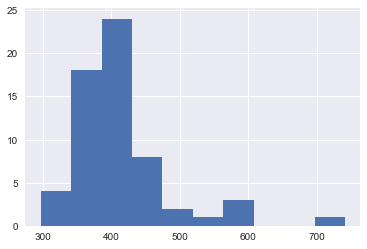

In [27]:
oa_secs = [x/512 for x in oa_lengths]
print(np.mean(oa_secs))
print(np.std(oa_secs))
print(np.max(oa_secs))
print(np.min(oa_secs))
plt.hist(oa_secs)

In [20]:
ya_secs = [x/512 for x in ya_lengths]
print(np.mean(ya_secs))
# print(np.max(y))
print(np.std(ya_secs))

609.220269097
92.1222349536


(array([  1.,   0.,   0.,   7.,  11.,   8.,   4.,   4.,   0.,   1.]),
 array([ 338.99804688,  391.99804688,  444.99804688,  497.99804688,
         550.99804688,  603.99804688,  656.99804688,  709.99804688,
         762.99804688,  815.99804688,  868.99804688]),
 <a list of 10 Patch objects>)

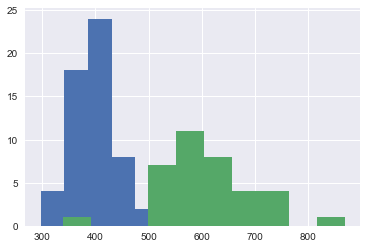

In [25]:
plt.hist(oa_secs)
plt.hist(ya_secs)

In [28]:
subj[0].keys()

dict_keys(['srate', 'nbchan', 'data', 'sex', 'events_eyeso', 'age', 'class', 'events', 'name', 'events_eyesc'])

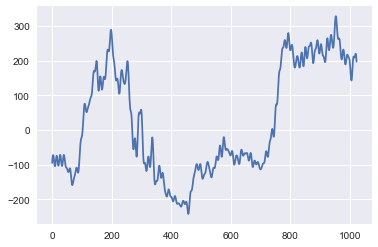

In [32]:
plt.plot(subj[0]['data'][0][0:2*512])

213411.0
37256.9233178
379391
152063


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  1.,  2.,  0.,  1.,  0.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  6.,  1.,  0.,  2.,  2.,  2.,
         0.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 173567. ,  176280.6,  178994.2,  181707.8,  184421.4,  187135. ,
         189848.6,  192562.2,  195275.8,  197989.4,  200703. ,  203416.6,
         206130.2,  208843.8,  211557.4,  214271. ,  216984.6,  219698.2,
         222411.8,  225125.4,  227839. ,  230552.6,  233266.2,  235979.8,
         238693.4,  241407. ,  244120.6,  246834.2,  249547.8,  252261.4,
         254975. ,  257688.6,  260402.2,  263115.8,  265829.4,  

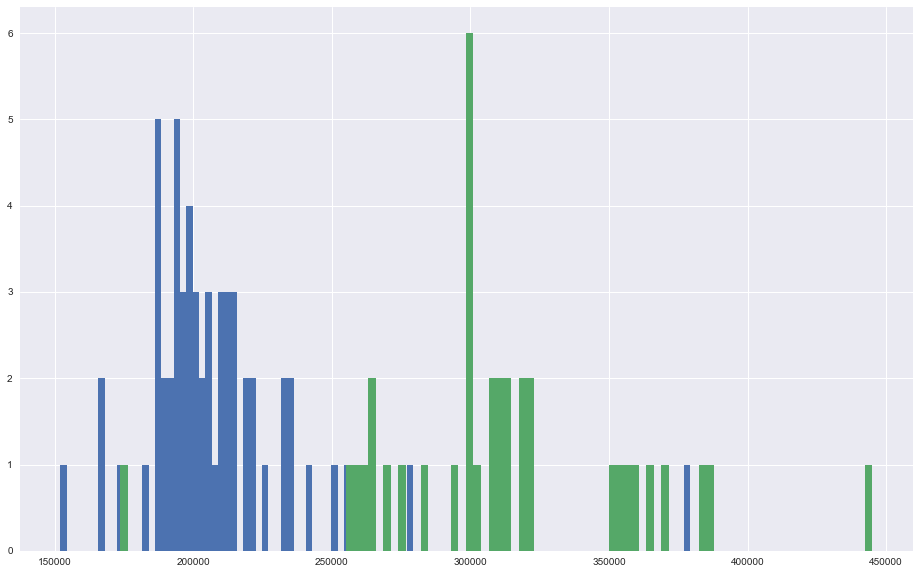

In [42]:
print(np.round(np.mean(oa_lengths)))
print(np.std(oa_lengths))
print(np.max(oa_lengths))
print(np.min(oa_lengths))
plt.hist(oa_lengths, bins=100)
plt.hist(ya_lengths, bins=100)

In [43]:
subj[0]['data'].shape

(48, 355327)

In [56]:
dat = subj[0]['data'][:, 0:213411]
dat.shape

(48, 213411)

In [55]:
dat.shape

(48, 10)

In [61]:
subj[0]['events'][-1]

['C2', 349043, 20]

In [62]:
ya_last_events

[['C2', 349043, 20],
 ['O2', 260372, 20],
 ['C2', 254920, 68],
 ['C2', 262366, 26],
 ['C2', 297180, 22],
 ['C2', 378378, 18],
 ['C2', 310942, 42],
 ['C2', 374627, 50],
 ['C2', 290538, 20],
 ['C2', 305551, 48],
 ['C2', 296050, 34],
 ['C2', 363552, 28],
 ['C2', 293643, 16],
 ['C2', 294665, 72],
 ['C2', 281073, 22],
 ['C2', 299415, 28],
 ['C2', 341868, 26],
 ['C2', 306234, 50],
 ['O2', 155077, 30],
 ['C2', 295311, 48],
 ['C2', 272099, 32],
 ['C2', 258652, 24],
 ['C2', 351929, 72],
 ['C2', 299496, 26],
 ['C2', 346422, 104],
 ['C2', 315787, 56],
 ['C2', 305742, 40],
 ['C2', 357133, 28],
 ['C2', 302696, 62],
 ['C2', 291896, 28],
 ['C2', 302343, 54],
 ['C2', 262055, 28],
 ['C2', 437812, 28],
 ['C2', 315126, 18],
 ['C2', 304892, 44],
 ['C2', 268654, 18]]

In [63]:
subj[0]['events_eyesc']

[[75766, 102799],
 [103823, 106383],
 [114448, 145145],
 [195274, 213808],
 [215139, 225994],
 [318425, 349043]]